In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import Dataset
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore warning of pandas
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

# Define a custom Dataset class to load data properly

Also define a function retrieving all dataloaders (training, validation and test).

In [60]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_idx = {label: idx for idx, label in enumerate(sorted(set(self.data["label"])))}
        self.mean = torch.tensor(self.data.iloc[:,2:-1].mean(), dtype=torch.float32) # Mean for each column
        self.std = torch.tensor(self.data.iloc[:,2:-1].std(), dtype=torch.float32) # Standard variation for each column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = torch.tensor(self.data.iloc[idx, 2:-1], dtype=torch.float32)
        label = torch.tensor(self.label_idx[self.data.iloc[idx][-1]])

        input = (input - self.mean)/self.std

        if self.transform:
            input = self.transform(input)

        return input, label
    
def get_dataloader(path, batch_size, transform):
    trainset = CustomDataset(path, transform=transform)

    # Split into train and validation
    indices = list(range(len(trainset)))
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)
    split_train = int(len(indices) * 0.7) # split at 70%
    split_test = int(len(indices) * 0.85) # split at 85%

    # Finally, train is 70% of total data, val: 15% and test 15%

    # split into training and validation indices
    train_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_test], indices[split_test:]
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    return train_loader, val_loader, test_loader

## Test to load data

In [63]:
# Fixed PyTorch random seed for reproducible result
torch.manual_seed(123)

train_loader, val_loader, test_loader = get_dataloader(
    "../../Data/features_3_sec.csv",
    batch_size=1,
    transform=None
)

In [64]:
# Check length for each loader
len(train_loader), len(val_loader),len(test_loader)

(6993, 1498, 1499)

## Define useful functions to plot and save training curve

In [154]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.savefig(path.replace(".", ",") + "_train_val_err")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig(path.replace(".", ",") + "_train_val_loss")
    plt.show()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        name: name of the model
        batch_size: size of the batch used during training
        learning_rate: learning rate value used during training
        epoch: epoch value
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format( name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

# Define model

Define model class as well as train and evaluate functions, very useful to train easily our model by just tweaking the hyperparameters.

In [159]:
class BaselineModel(nn.Module):
    """
        A very basic baseline model
    """
    def __init__(self) -> None:
        super(BaselineModel, self).__init__()
        self.name = "baseline"
        self.fc1 = nn.Linear(57, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10) # Classify between 10 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self, path, batch_size=1, learning_rate=0.01, num_epochs=10):
        train_loader, val_loader, _ = get_dataloader(path, batch_size=batch_size, transform=None)

        ########################################################################
        # Define the Loss function and optimizer
        # The loss function will be Cross Entropy.
        # Optimizer will be Adam.
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        ########################################################################
        # Set up some numpy arrays to store the training/test loss/erruracy
        train_err = np.zeros(num_epochs)
        train_loss = np.zeros(num_epochs)
        val_err = np.zeros(num_epochs)
        val_loss = np.zeros(num_epochs)
        ########################################################################
        # Train the network
        # Loop over the data iterator and sample a new batch of train(train_loader, val_loader, ing data
        # Get the output from the network, and optimize our loss function.
        start_time = time.time()
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            total_train_loss = 0.0
            total_train_err = 0.0
            total_epoch = 0
            for i, data in enumerate(train_loader, 0):
                # Get the inputs
                inputs, labels = data
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward pass, backward pass, and optimize
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # Calculate the statistics
                corr = (torch.argmax(outputs,1) != labels)
                total_train_err += int(corr.sum())
                total_train_loss += loss.item()
                total_epoch += len(labels)
            train_err[epoch] = float(total_train_err) / total_epoch
            train_loss[epoch] = float(total_train_loss) / (i+1)
            val_err[epoch], val_loss[epoch] = self.evaluate(val_loader, criterion)
            print(("Epoch {}: Train err: {}, Train loss: {} |"+
                "Validation err: {}, Validation loss: {}").format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        # Save the trained model to a file
        model_path = get_model_name(self.name, batch_size, learning_rate, epoch)
        torch.save(self.state_dict(), model_path)
        print('Finished Training')
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
        # Write the train/test loss/err into CSV file for plotting later
        np.savetxt("{}_train_err.csv".format(model_path), train_err)
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_err.csv".format(model_path), val_err)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    def evaluate(self, loader, criterion):
        """ Evaluate the network on the validation set.

        Args:
            loader: PyTorch data loader for the validation set
            criterion: The loss function
        Returns:
            err: A scalar for the avg classification error over the validation set
            loss: A scalar for the average loss function over the validation set
        """
        total_loss = 0.0
        total_err = 0.0
        total_epoch = 0
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            corr = (torch.argmax(outputs,1) != labels)
            total_err += int(corr.sum())
            total_loss += loss.item()
            total_epoch += len(labels)
        err = float(total_err) / total_epoch
        loss = float(total_loss) / (i + 1)
        return err, loss

# Train over features_3s.csv datafile

Epoch 1: Train err: 0.6166166166166166, Train loss: 1.8178328798241812 |Validation err: 0.4886515353805073, Validation loss: 1.4084401942313987
Epoch 2: Train err: 0.44816244816244816, Train loss: 1.2643033611720011 |Validation err: 0.37449933244325767, Validation loss: 1.1281799864261708
Epoch 3: Train err: 0.3582153582153582, Train loss: 1.0545662777608933 |Validation err: 0.3324432576769025, Validation loss: 0.9857082569852789
Epoch 4: Train err: 0.30945230945230945, Train loss: 0.9276574384676267 |Validation err: 0.29506008010680906, Validation loss: 0.9011397222255139
Epoch 5: Train err: 0.2782782782782783, Train loss: 0.8420728487239036 |Validation err: 0.27970627503337786, Validation loss: 0.829180491731522
Epoch 6: Train err: 0.25825825825825827, Train loss: 0.776333065882121 |Validation err: 0.2583444592790387, Validation loss: 0.7868619840195838
Epoch 7: Train err: 0.24495924495924495, Train loss: 0.7281881147595846 |Validation err: 0.25033377837116155, Validation loss: 0.744

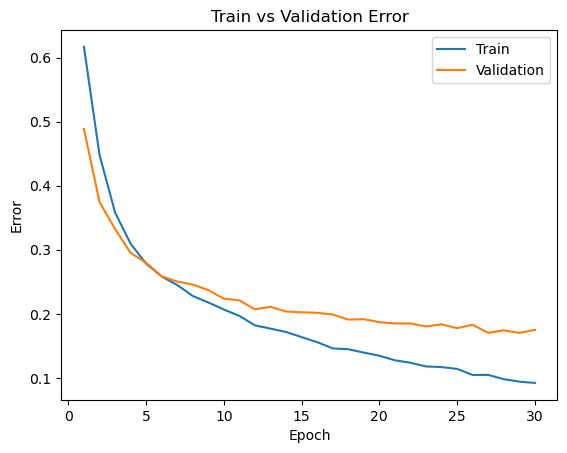

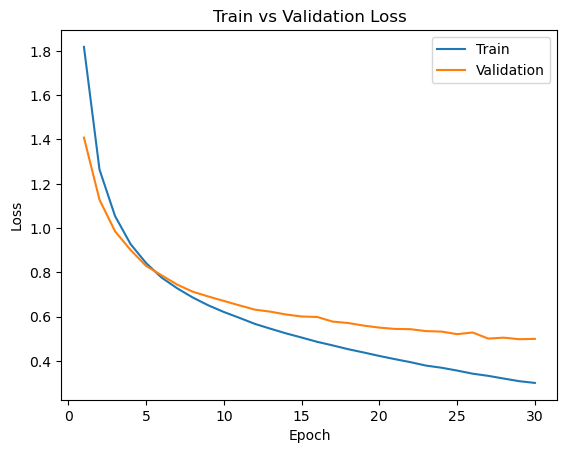

In [143]:
baseline = BaselineModel()
batch_size=32
learning_rate=0.0002
num_epochs=30

baseline.train("../../Data/features_3_sec.csv", batch_size, learning_rate, num_epochs)
model_path = get_model_name("baseline", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train err: 0.6206206206206206, Train loss: 1.8402747492811995 |Validation err: 0.493324432576769, Validation loss: 1.4284035779060202
Epoch 2: Train err: 0.4382954382954383, Train loss: 1.2690331905944163 |Validation err: 0.39118825100133514, Validation loss: 1.1298849430490048
Epoch 3: Train err: 0.3605033605033605, Train loss: 1.0554775726305294 |Validation err: 0.36114819759679573, Validation loss: 1.0012779400703755
Epoch 4: Train err: 0.3178893178893179, Train loss: 0.9282130773209002 |Validation err: 0.30240320427236317, Validation loss: 0.893591081842463
Epoch 5: Train err: 0.28113828113828115, Train loss: 0.8418239491170945 |Validation err: 0.28371161548731644, Validation loss: 0.8356344236972484
Epoch 6: Train err: 0.26140426140426143, Train loss: 0.777508651965285 |Validation err: 0.27436582109479307, Validation loss: 0.7987959213713383
Epoch 7: Train err: 0.24624624624624625, Train loss: 0.7274597454560946 |Validation err: 0.25166889185580776, Validation loss: 0.752

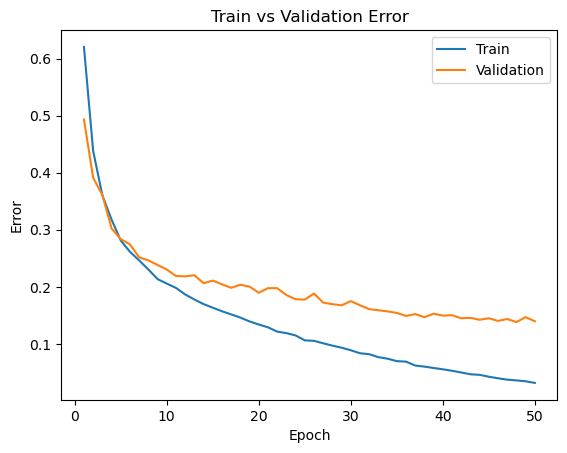

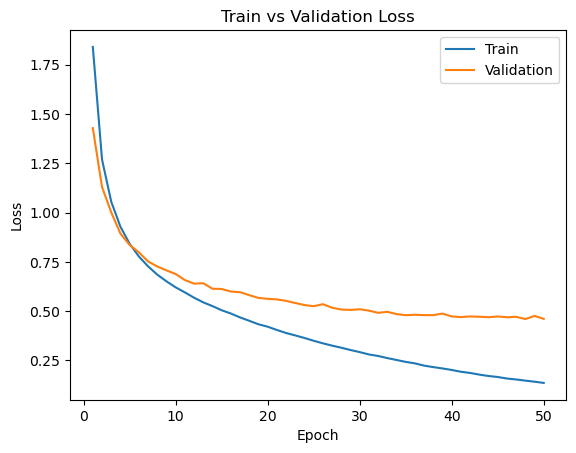

In [144]:
baseline = BaselineModel()
batch_size=32
learning_rate=0.0002
num_epochs=50

baseline.train("../../Data/features_3_sec.csv", batch_size, learning_rate, num_epochs)
model_path = get_model_name("baseline", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train err: 0.6589446589446589, Train loss: 1.9005875717509877 |Validation err: 0.5080106809078772, Validation loss: 1.492409239212672
Epoch 2: Train err: 0.4596024596024596, Train loss: 1.3129761955954813 |Validation err: 0.3931909212283044, Validation loss: 1.1673725545406342
Epoch 3: Train err: 0.3743743743743744, Train loss: 1.0834318914196708 |Validation err: 0.3417890520694259, Validation loss: 0.9988045518596967
Epoch 4: Train err: 0.323037323037323, Train loss: 0.9488281412558122 |Validation err: 0.2983978638184246, Validation loss: 0.9046255523959795
Epoch 5: Train err: 0.2878592878592879, Train loss: 0.8513209207491441 |Validation err: 0.27903871829105475, Validation loss: 0.8326422323783239
Epoch 6: Train err: 0.26054626054626057, Train loss: 0.7811947562477806 |Validation err: 0.25567423230974634, Validation loss: 0.7851209044456482
Epoch 7: Train err: 0.2408122408122408, Train loss: 0.7251299253918908 |Validation err: 0.24499332443257676, Validation loss: 0.7453353

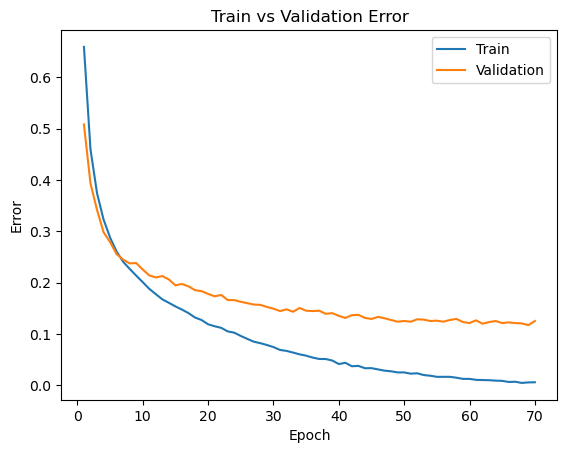

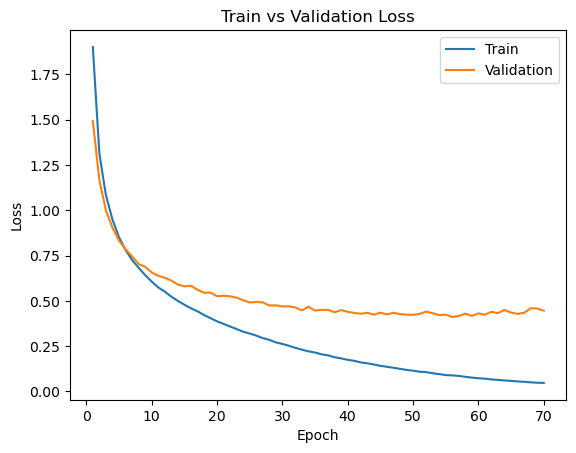

In [145]:
baseline = BaselineModel()
batch_size=64
learning_rate=0.0003
num_epochs=70

baseline.train("../../Data/features_3_sec.csv", batch_size, learning_rate, num_epochs)
model_path = get_model_name("baseline", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

## Retrieve best model and measure its accuracy on test loader

In [165]:
# Load best model
batch_size=64
learning_rate=0.0003
num_epochs=70

best_model_path = get_model_name("baseline", batch_size, learning_rate, num_epochs-1)
best_model = BaselineModel()

best_model.load_state_dict(torch.load(best_model_path))

_, _, test_loader = get_dataloader("../../Data/features_3_sec.csv", batch_size=batch_size, transform=None)
criterion = nn.CrossEntropyLoss()
err, loss = best_model.evaluate(test_loader, criterion=criterion)

print("Test error: {0}, Test loss: {1}".format(err, loss))

Test error: 0.1247498332221481, Test loss: 0.511285121863087


# Train over features_30s.csv datafile

In [167]:
class BaselineModel30s(nn.Module):
    """
        A very basic baseline model
    """
    def __init__(self) -> None:
        super(BaselineModel30s, self).__init__()
        self.name = "baseline30s"
        self.fc1 = nn.Linear(57, 30)
        self.fc2 = nn.Linear(30, 10) # Classify between 10 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def train(self, path, batch_size=1, learning_rate=0.01, num_epochs=10):
        train_loader, val_loader, _ = get_dataloader(path, batch_size=batch_size, transform=None)

        ########################################################################
        # Define the Loss function and optimizer
        # The loss function will be Cross Entropy.
        # Optimizer will be Adam.
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        ########################################################################
        # Set up some numpy arrays to store the training/test loss/erruracy
        train_err = np.zeros(num_epochs)
        train_loss = np.zeros(num_epochs)
        val_err = np.zeros(num_epochs)
        val_loss = np.zeros(num_epochs)
        ########################################################################
        # Train the network
        # Loop over the data iterator and sample a new batch of train(train_loader, val_loader, ing data
        # Get the output from the network, and optimize our loss function.
        start_time = time.time()
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            total_train_loss = 0.0
            total_train_err = 0.0
            total_epoch = 0
            for i, data in enumerate(train_loader, 0):
                # Get the inputs
                inputs, labels = data
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward pass, backward pass, and optimize
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # Calculate the statistics
                corr = (torch.argmax(outputs,1) != labels)
                total_train_err += int(corr.sum())
                total_train_loss += loss.item()
                total_epoch += len(labels)
            train_err[epoch] = float(total_train_err) / total_epoch
            train_loss[epoch] = float(total_train_loss) / (i+1)
            val_err[epoch], val_loss[epoch] = self.evaluate(val_loader, criterion)
            print(("Epoch {}: Train err: {}, Train loss: {} |"+
                "Validation err: {}, Validation loss: {}").format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        # Save the trained model to a file
        model_path = get_model_name(self.name, batch_size, learning_rate, epoch)
        torch.save(self.state_dict(), model_path)
        print('Finished Training')
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
        # Write the train/test loss/err into CSV file for plotting later
        np.savetxt("{}_train_err.csv".format(model_path), train_err)
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_err.csv".format(model_path), val_err)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    def evaluate(self, loader, criterion):
        """ Evaluate the network on the validation set.

        Args:
            loader: PyTorch data loader for the validation set
            criterion: The loss function
        Returns:
            err: A scalar for the avg classification error over the validation set
            loss: A scalar for the average loss function over the validation set
        """
        total_loss = 0.0
        total_err = 0.0
        total_epoch = 0
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            corr = (torch.argmax(outputs,1) != labels)
            total_err += int(corr.sum())
            total_loss += loss.item()
            total_epoch += len(labels)
        err = float(total_err) / total_epoch
        loss = float(total_loss) / (i + 1)
        return err, loss

Epoch 1: Train err: 0.8342857142857143, Train loss: 2.2813029939478096 |Validation err: 0.8066666666666666, Validation loss: 2.2128252744674684
Epoch 2: Train err: 0.7114285714285714, Train loss: 2.101975766095248 |Validation err: 0.6733333333333333, Validation loss: 2.052338218688965
Epoch 3: Train err: 0.6028571428571429, Train loss: 1.9271767112341793 |Validation err: 0.5866666666666667, Validation loss: 1.9011151194572449
Epoch 4: Train err: 0.5814285714285714, Train loss: 1.7703952410004355 |Validation err: 0.56, Validation loss: 1.7405342698097228
Epoch 5: Train err: 0.5657142857142857, Train loss: 1.6385988999496808 |Validation err: 0.56, Validation loss: 1.644257378578186
Epoch 6: Train err: 0.5328571428571428, Train loss: 1.5369444028897719 |Validation err: 0.5466666666666666, Validation loss: 1.5457465887069701
Epoch 7: Train err: 0.5028571428571429, Train loss: 1.4524993977763436 |Validation err: 0.52, Validation loss: 1.4836525678634644
Epoch 8: Train err: 0.465714285714285

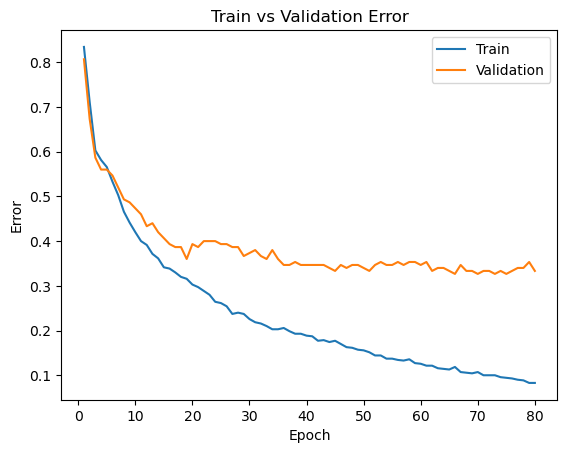

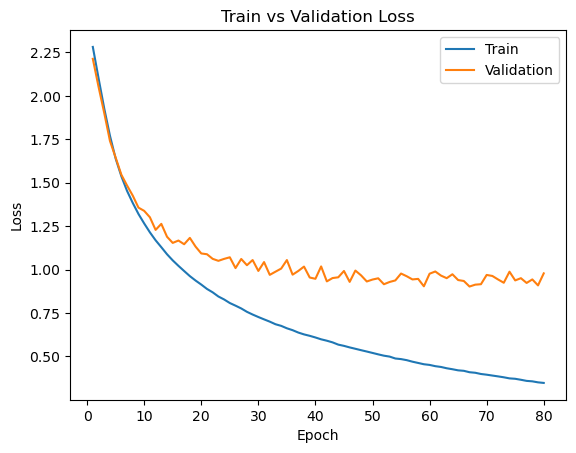

In [192]:
baseline30s = BaselineModel30s()
batch_size=16
learning_rate=0.0005
num_epochs=80

baseline30s.train("../../Data/features_30_sec.csv", batch_size, learning_rate, num_epochs)
model_path = get_model_name("baseline30s", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

## Measure best model performance on test loader

In [191]:
# Load best model
batch_size=16
learning_rate=0.0005
num_epochs=80

best_model_path = get_model_name("baseline30s", batch_size, learning_rate, num_epochs-1)
best_model = BaselineModel30s()

best_model.load_state_dict(torch.load(best_model_path))

_, _, test_loader = get_dataloader("../../Data/features_30_sec.csv", batch_size=batch_size, transform=None)
criterion = nn.CrossEntropyLoss()
err, loss = best_model.evaluate(test_loader, criterion=criterion)

print("Test error: {0}, Test loss: {1}".format(err, loss))

Test error: 0.2866666666666667, Test loss: 0.8834511816501618
